In [1]:
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
from collections import Counter
%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# Shape Files

In [2]:
# download from here: https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html
sf = shp.Reader("cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")

In [56]:
def is_manhattan_zipcode(zipcode, min_zip=10000, max_zip=10300):
    return min_zip <= int(zipcode) <= max_zip

def emit_nyc_shapes():
    for record, shape in zip(sf.iterRecords(), sf.iterShapes()):
        zipcode = record[0]
        if is_manhattan_zipcode(zipcode):
            coords = np.array(shape.points)
            yield zipcode, coords

In [57]:
def plot_nyc_shapes():
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca()
    for _, coords in emit_nyc_shapes():
        plt.plot(coords[:, 0], coords[:, 1], 'k-')
    ax.set_aspect('equal')

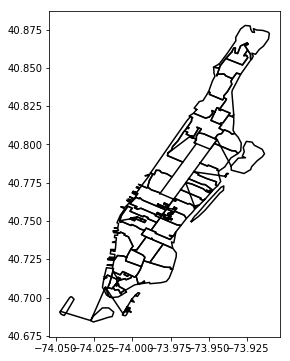

In [58]:
plot_nyc_shapes()

## Load and Clean Data

In [10]:
def load_manhattan_zips(fname='manhattan_zip_codes.tsv', sep='\t'):
    df = pd.read_csv(fname, sep=sep)
    return df

In [11]:
df_zip = load_manhattan_zips()

In [12]:
def load_census_data(fname='census_data.csv',
                     usecols=(0, 1, 3)):
    df = pd.read_csv(fname, usecols=usecols, thousands=',')
    df.columns = ['Zip Code', 'Median Income', 'Population']
    return df

In [13]:
df_census = load_census_data()

In [14]:
def load_store_data(fname='df_yelp_cleaned_up.csv'):
    df = pd.read_csv(fname, index_col=0)
    return df

In [15]:
df_stores = load_store_data()

In [19]:
def merge_all_df(df_zip, df_stores, df_census):
    df_stores_grouped = df_stores.groupby(by=['Zip Code']).size().reset_index(name='Store Count')
    df_all = df_zip.merge(df_stores_grouped, how='left', on='Zip Code')
    df_all = df_all.merge(df_census, how='left', on='Zip Code')
    df_all['Store Count'].fillna(0, inplace=True)
    return df_all

In [29]:
def cleanup_df(df, min_pop=100, pop_scale=10000, income_scale=100000):
    idx_bad = (df['Population'].isnull()) | (df['Population'] < min_pop)
    df = df[~idx_bad] # strip out "empty" zips
    df['PopScaled'] = df['Population']/pop_scale
    df['MedIncomeScaled'] = df['Median Income']/income_scale
    return df

In [30]:
df_all = merge_all_df(df_zip, df_stores, df_census)
df_all = cleanup_df(df_all)

In [31]:
df_all.shape

(44, 7)

In [129]:
df_stores.shape

(531, 8)

# PyMC

In [16]:
# y ~ NBD(mu=u*exp(Xi*B), overdispersion=omega)

In [34]:
import pymc3 as pm

## Poisson

### Bare Zip Codes

In [36]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    intercept = pm.Normal('intercept', mu=0., sd=10.)
    sigma = pm.HalfNormal('sigma', sd=10.)
    alpha_zip = pm.Normal('alpha_zip', mu=0., sd=sigma, shape=df_all.shape[0])
    
    # define linear model and exp link function
    theta = intercept + alpha_zip
    mu = df_all['PopScaled'].values * np.exp(theta)

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=mu, observed=df_all['Store Count'])

In [37]:
with model:
    res = pm.variational.advi()
    trace = pm.sample(20000, start=res.means, njobs=2, step=pm.NUTS())

Average ELBO = -301.37: 100%|██████████| 5000/5000 [00:00<00:00, 12114.70it/s]
Finished [100%]: Average ELBO = -275.71
100%|██████████| 20000/20000 [01:47<00:00, 186.22it/s]


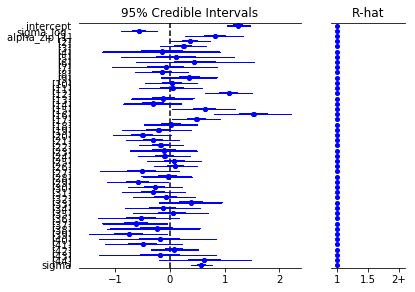

In [46]:
pm.forestplot(trace[1000:])

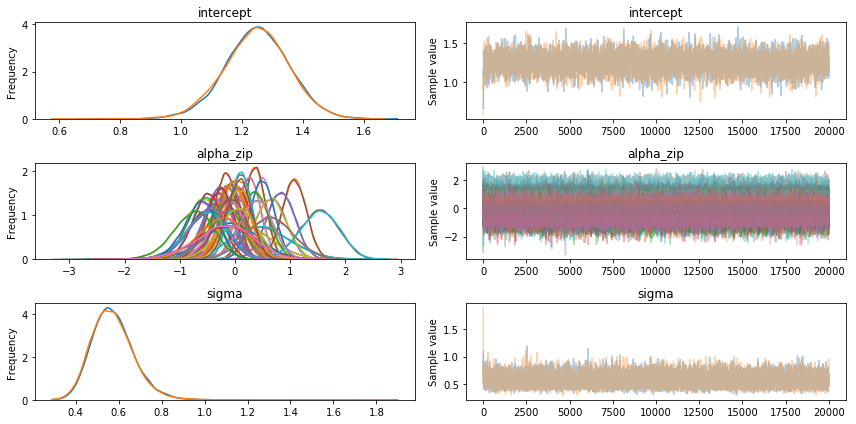

In [39]:
pm.traceplot(trace[1000:])

### Including Income

In [120]:
with pm.Model() as model_income:
    # define (weakly informative) priors
    intercept = pm.Normal('intercept', mu=0., sd=10.)
    beta = pm.Normal('beta', mu=0., sd=10.)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sd=10.)
    alpha_zip = pm.Normal('alpha_zip',
                          mu=0.,
                          sd=sigma_alpha,
                          shape=df_all.shape[0])
    
    # linear model w/ exp link function
    theta = intercept + alpha_zip + beta * np.log(df_all['MedIncomeScaled'].values)
    mu = df_all['PopScaled'].values*np.exp(theta)

    # likelihood
    y = pm.Poisson('y', mu=mu, observed=df_all['Store Count'])

In [121]:
with model_income:
    res_income = pm.variational.advi()
    trace_income = pm.sample(20000, start=res_income.means, njobs=2, step=pm.NUTS())

Average ELBO = -354: 100%|██████████| 5000/5000 [00:00<00:00, 11173.71it/s]   
Finished [100%]: Average ELBO = -320.93
100%|██████████| 20000/20000 [02:02<00:00, 163.89it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f45dba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119a12ac8>]], dtype=object)

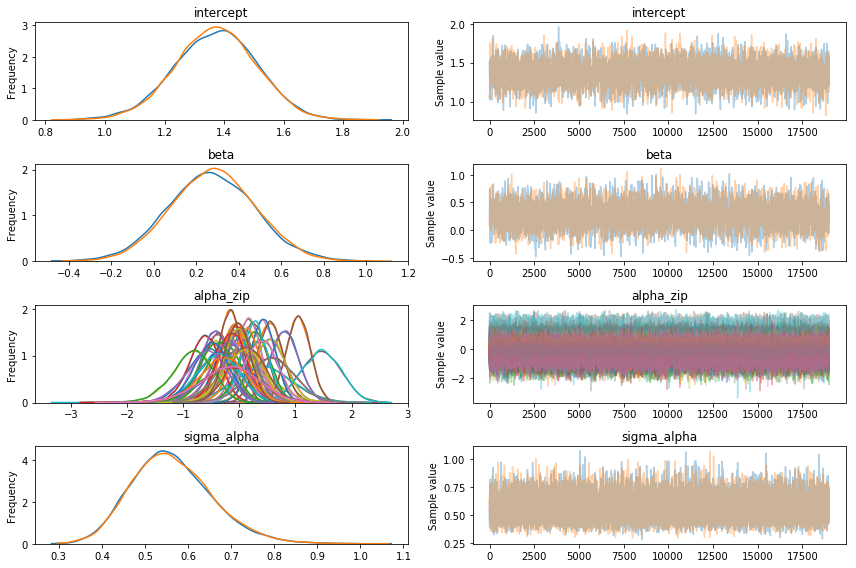

In [122]:
pm.traceplot(trace_income[1000:])

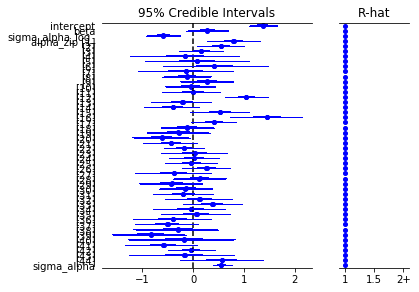

In [123]:
pm.forestplot(trace_income[1000:])

In [49]:
def compute_final_means(trace):
    df_means = pd.DataFrame({'mean': trace[1000:].get_values('alpha_zip').mean(axis=0),
                             'neighborhood': df_all['Neighborhood'],
                             'zip': df_all['Zip Code']})
    return df_means

In [50]:
df_means = compute_final_means(trace)

In [125]:
df_means_income = compute_final_means(trace_income)

# Combine Means with Map -> Choropleth

In [64]:
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [113]:
def plot_nyc_means(df_means):
    lookup = dict(zip(df_means['zip'], df_means['mean']))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca()
    polygons = []
    colors = []
    for zipcode, coords in emit_nyc_shapes():
        if int(zipcode) in lookup:
            mean = lookup[int(zipcode)]
            polygon = Polygon(coords, True)
            polygons.append(polygon)
            colors.append(mean)
            ax.plot(coords[:, 0], coords[:, 1], 'k-')
    p = PatchCollection(polygons, cmap=cm.OrRd, alpha=0.4)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    plt.tight_layout()
    ax.set_aspect('equal', 'datalim')
    plt.show()

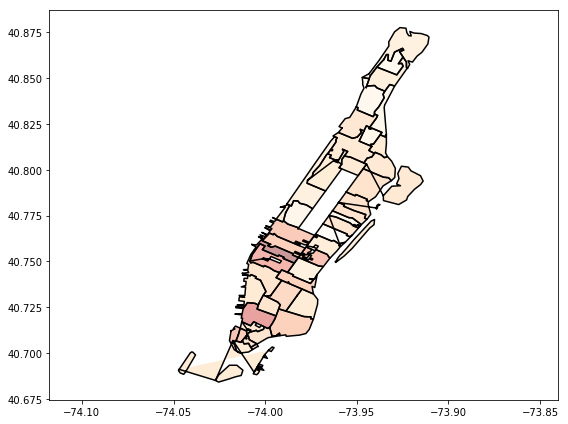

In [116]:
colors = plot_nyc_means(df_means)

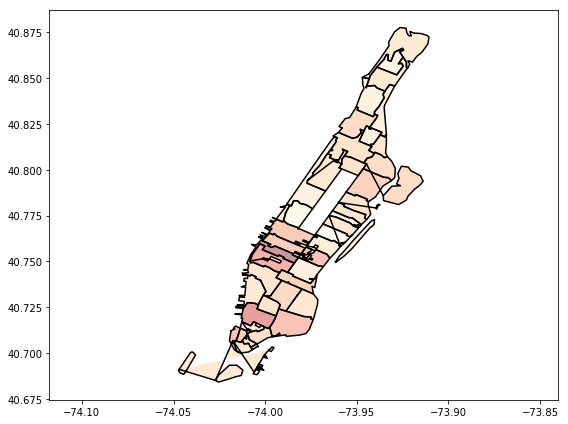

In [126]:
colors = plot_nyc_means(df_means_income)